<a href="https://colab.research.google.com/github/Fulmenius/Predicting-antibody-escape-with-ML/blob/XGBoost/EDA_and_XGBoost_of_ACE2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import numpy as np
import pandas as pd
import xgboost
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style("whitegrid")


In [52]:
ACE2_train = pd.read_csv("ACE2_train_data.csv")
ACE2_test = pd.read_csv("ACE2_test_data.csv")

Fist we analyze the data a bit

In [53]:
ACE2_train.head()

,Unnamed: 0,junction_aa,consensus_count,Label,Distance
0,287261,KNAGFNCYNPLETYGFWRTGGVDW,1,1,9
1,467439,KNEQFNCYGPINAYGFQRTGGEDW,1,0,10
2,414422,KNQKFNCYVPLFHYGFWPTVGVGF,1,1,8
3,103144,KNQGFNCYNPLVNYGFYRTNGRSF,1,1,9
4,478954,KNRGFNCYKPLPGYGFQRTDGINW,2,0,9


In [54]:
ACE2_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406886 entries, 0 to 406885
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       406886 non-null  int64 
 1   junction_aa      406886 non-null  object
 2   consensus_count  406886 non-null  int64 
 3   Label            406886 non-null  int64 
 4   Distance         406886 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 15.5+ MB


In [55]:
ACE2_train.describe()

,Unnamed: 0,consensus_count,Label,Distance
count,406886.000000,406886.000000,406886.000000,406886.000000
mean,323195.466440,1.443908,0.500027,9.017398
std,189813.180032,1.423285,0.500001,1.167593
min,0.000000,1.000000,0.000000,1.000000
25%,154232.250000,1.000000,0.000000,8.000000
50%,325632.500000,1.000000,1.000000,9.000000
75%,483459.500000,2.000000,1.000000,10.000000
max,663081.000000,310.000000,1.000000,12.000000


In [56]:
ACE2_train['Distance'].value_counts().sort_values()

1          4
4         48
5        553
2        705
3       1123
12      2737
6       4691
7      25045
11     30307
8      82354
10     98928
9     160391
Name: Distance, dtype: int64

In [57]:
ACE2_train['consensus_count'].value_counts()

1      301497
2       66913
3       23601
4        8100
5        3607
        ...  
50          1
57          1
99          1
122         1
102         1
Name: consensus_count, Length: 72, dtype: int64

<ipython-input-58-6ba3987c3563>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ACE2_train.consensus_count, bins = 30, ax=axes[0], kde=False, hist_kws={'log':True})
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2502: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.hist(a, bins, orientation=orientation,
<ipython-input-58-6ba3987c3563>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For 

Text(0.5, 1.0, 'Distance')

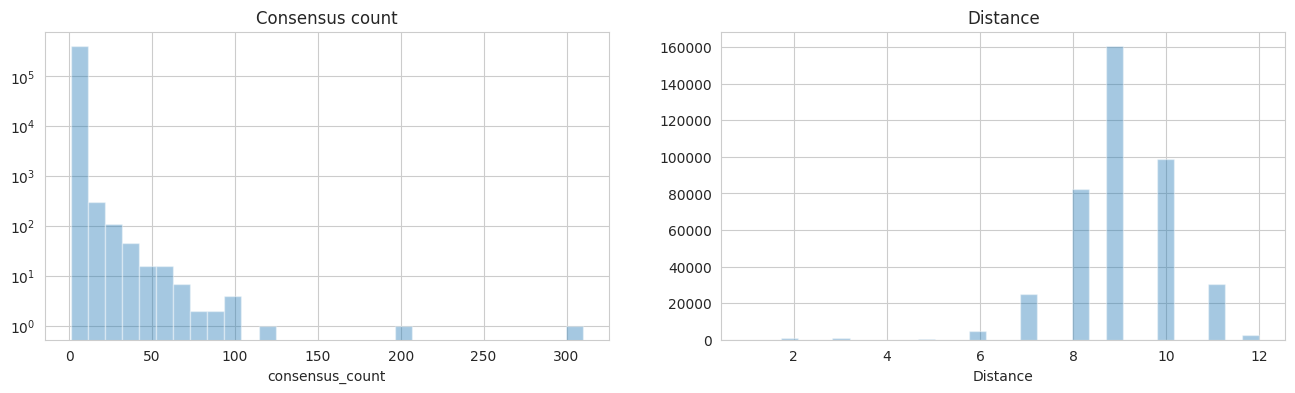

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
ax = sns.distplot(ACE2_train.consensus_count, bins = 30, ax=axes[0], kde=False, hist_kws={'log':True})
ax.set_title("Consensus count")
ax = sns.distplot(ACE2_train.Distance, bins = 30, ax=axes[1], kde=False)
ax.set_title("Distance")

Text(0.5, 1.0, 'Correlation between consensus count and distance')

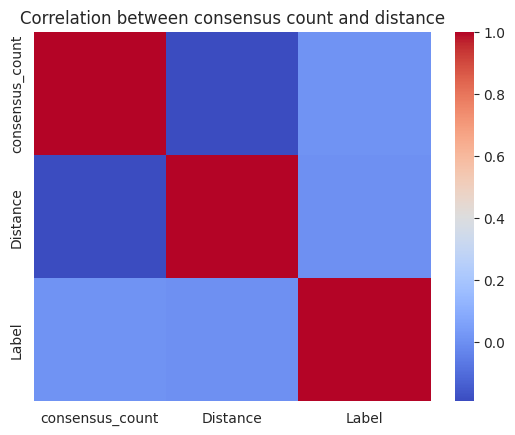

In [59]:
fig = plt.plot(figsize=(4, 4))

ax = sns.heatmap(ACE2_train[['consensus_count', 'Distance', 'Label']].corr(), cmap='coolwarm')
ax.set_title('Correlation between consensus count and distance')


Text(0.5, 1.0, 'Something')

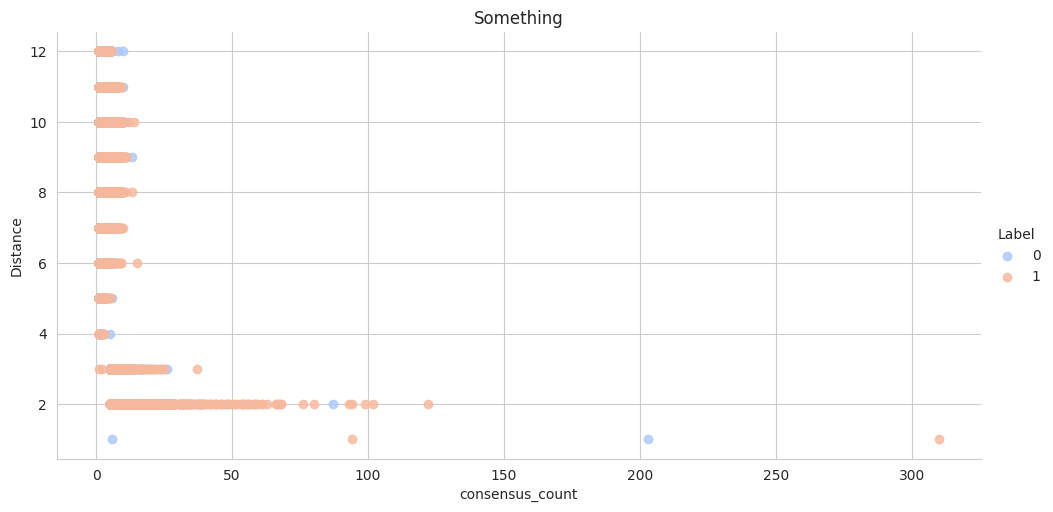

In [60]:
sns.lmplot(x='consensus_count', y='Distance', hue='Label', data=ACE2_train, fit_reg=False, palette='coolwarm', aspect=2)
plt.title('Something')

## One-hot encoding
'junction_aa' is a sequence from RBD, of length 24. We represent each letter with a 20-dimensional vector.

In [61]:
def vocabulary(series):
    """
    This function creates a vocabulary of letters in the dataset 
    """
    un_val = series.apply(lambda x: set(list(x))).tolist()
    un_val = set().union(*un_val)
    return list(un_val)

vocab = vocabulary(ACE2_train['junction_aa'])

"""
One-hot encoding. No padding is needed, because all strings have a length of 24
"""
def one_hot_encode(series, aa_vocab):
    length = 24
    encoding = lambda x: np.array([[letter == aa_vocab[i] for i in range(len(aa_vocab))] for letter in x])
    
    return series.apply(encoding)

In [62]:
"""
Pre-process test and train data
"""
ACE2_train['junction_aa_encoded'] = one_hot_encode(ACE2_train['junction_aa'], list(vocab))
ACE2_test['junction_aa_encoded'] = one_hot_encode(ACE2_test['junction_aa'], list(vocab))

In [66]:
from xgboost import XGBClassifier

In [79]:
import time

X_train = np.stack(ACE2_train['junction_aa_encoded'].apply(lambda x: x.flatten()).values)
y_train = ACE2_train['Label'].values
X_test = np.stack(ACE2_test['junction_aa_encoded'].apply(lambda x: x.flatten()).values)
y_test = ACE2_test['Label'].values



In [78]:
X_train.shape

(406886, 480)

In [80]:

xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction accuracy is: 92.82
Time consumed for training: 918.746
Time consumed for prediction: 0.31641 seconds


In [ ]:
from sklearn.model_selection import cross_val_score

xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict

predictions = cross_val_predict(xgb, X_train, y_train, cv=3)

print("Precision:", precision_score(X_test, predictions, average='micro'))
print("Recall:",recall_score(X_test, predictions, average='micro'))
print("F1-Score:", f1_score(X_test, predictions, average='micro'))